# notebook for determining FE55 gains and camera charge diffusion

Eric Charles and Bo Xin

References:

    o. https://github.com/lsst/bootcamp-work/blob/master/examples/welcome_to_FE55.ipynb

    o. https://github.com/lsst-camera-dh/eotest/blob/master/python/lsst/eotest/sensor/fe55_psf.py

### Setup

Before running this notebook, you'll need to set up the `obs_lsst` package. Before doing the setup procedure below, you might want to run the notebook until it crashes so you see what the error message looks like.

Step-by-step instructions:

1. Start a terminal in JupyterLab. In the terminal, setup the Stack with the command `source /opt/lsst/software/stack/loadLSST.bash` and then issue the command `setup lsst_distrib` to allow you to run scons in a subsequent step.

2. Create and/or switch into a folder where you want to put your local versions of the LSST Stack (e.g., `~/repos`)

Run the following commands

```
git clone https://github.com/lsst/obs_lsstCam.git
cd obs_lsstCam
setup -j -r .
scons
```

3. Add `setup -k -r path_to_repos/obs_lsstCam` to `$HOME/notebooks/.user_setups`.

4. Restart your kernel.

Just for fun, check what version of the Stack you are using. This notebook has been tested on `w_2018_45`.

In [ ]:
! eups list -s | grep lsst_distrib

### Imports

In [ ]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
from scipy.optimize import leastsq
import numpy
import os
import yaml

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.detection as afwDetection
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath

# Firefly client imports
from firefly_client import FireflyClient
from IPython.display import IFrame

import FE55_psf_func
import stats_utils
from scipy.special import erf, gammaincc

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [ ]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False

### Construct the `IsrTask` with the above configuration

In [ ]:
isr = IsrTask(config=isr_config)

### Retrieve the data necessary to perform ISR.  This is just the raw data and the bias frame.  Note there are multiple integrations.  This notebook only looks at one of them.

In [ ]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
print(butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FE55', 'testType': 'FE55'}))

dId = {'visit': 258334666, 'detector': 2}
raw = butler.get('raw', **dId)
bias = butler.get('bias', **dId)

In [ ]:
result = isr.run(raw, bias=bias)

### Set up the necessary classes for using firefly to look at the data.

In [ ]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600)

In [ ]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

### Disaplay the frame after ISR

In [ ]:
#afw_display.mtv(result.exposure)

### Set up the functions doing the fit

In [ ]:
def double_gaussian(x, params):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =  c1 * numpy.exp(-(x - mu1)**2.0/(2.0 * sigma1**2.0)) \
          + c2 * numpy.exp(-(x - mu2)**2.0/(2.0 * sigma2**2.0))
    return res

def double_gaussian_fit(params, x, y):
    fit = double_gaussian( x, params )
    return (fit - y)

In [ ]:
def fit_single_footprint(fp, **kwargs):

    # input arguments
    npars = kwargs.get('npars', 5)
    min_npix = kwargs.get('min_npix', 9)
    max_npix = kwargs.get('max_npix', 100)
    stdev = kwargs.get('stdev')
    sigma0 = kwargs.get('sigma0', 0.36)
    dn0 = kwargs.get('dn0', 1590./5.)
    
    # input data
    imarr = kwargs.get('imarr')
    
    # variables we are filling
    zvals = kwargs.get('zvals', [])
    sigmax = kwargs.get('sigmax', [])
    sigmay = kwargs.get('sigmay', [])
    dn = kwargs.get('dn', [])
    x0 = kwargs.get('x0', [])
    y0 = kwargs.get('y0', [])
    aList = kwargs.get('a', [])
    bList = kwargs.get('b', [])
    cList = kwargs.get('c', [])
    dn_fp = kwargs.get('dn_fp', [])
    chiprob = kwargs.get('chiprob', [])
    chi2s = kwargs.get('chi2s', [])
    dofs = kwargs.get('dofs', [])
    maxDNs = kwargs.get('maxDN', [])
    p9_data = kwargs.get('p9_data', [])
    p9_model = kwargs.get('p9_model', [])
    prect_data = kwargs.get('prect_data', [])
    xpeak = kwargs.get('xpeak', [])
    ypeak = kwargs.get('ypeak', [])
    
    if fp.getArea() < min_npix or fp.getArea() > max_npix:            
        return -1
    spans = fp.getSpans()
    positions = []
    zvals = []
    peak = [pk for pk in fp.getPeaks()][0]
    dn_sum = 0
    a_0 = 0.0
    b_0 = 0.0
    c_0 = 100.
    
    for span in spans:
        y = span.getY()
        for x in range(span.getX0(), span.getX1() + 1):
            ym = y%imarr.shape[0]
            xm = x%imarr.shape[1]
            zvals.append(imarr[ym][xm])
            dn_sum += imarr[ym][xm]
            positions.append((x, y))
                
    try:
        # Use clipped stdev as DN error estimate for all pixels
        dn_errors = stdev*numpy.ones(len(positions))
        if npars == 5:
            p0 = (peak.getIx(), peak.getIy(), sigma0, sigma0, dn0, a_0, b_0, c_0)
            pars, _ = leastsq(FE55_psf_func.residuals, p0, args=(positions, zvals, dn_errors))
            sigx = pars[2]
            sigy = pars[3]
            dnval = pars[4]
        else:
            p0 = (peak.getIx(), peak.getIy(), sigma0, dn0, a_0, b_0, c_0)
            pars, _ = leastsq(FE55_psf_func.residuals_single, p0, args=(positions, zvals, dn_errors))
            sigx = pars[2]
            sigy = pars[2]
            dnval = pars[3]
        chi2 = FE55_psf_func.chisq(positions, zvals, pars[0], pars[1], sigx, sigy, dnval, dn_errors)
        dof = fp.getArea() - npars
        prob = gammaincc(dof/2., chi2/2.)        
        if prob < 1e-2:
            return -1
        if npars == 5:            
            sigmax.append(pars[2])
            sigmay.append(pars[3])
            dn.append(pars[4])
            aList.append(pars[5])
            bList.append(pars[6])
            cList.append(pars[7])
        else:
            sigmax.append(pars[2])
            sigmay.append(pars[2])
            dn.append(pars[3])
            aList.append(pars[4])
            bList.append(pars[5])
            cList.append(pars[6])
        x0.append(pars[0])
        y0.append(pars[1])
        dn_fp.append(dn_sum)
        chi2 = FE55_psf_func.chisq(positions, zvals, x0[-1], y0[-1], sigmax[-1], sigmay[-1], dn[-1], 
                                   aList[-1], bList[-1], cList[-1], dn_errors)
        dof = fp.getArea() - npars
        chiprob.append(gammaincc(dof/2., chi2/2.))
        chi2s.append(chi2)
        dofs.append(dof)
        maxDNs.append(max(zvals))
        try:
            #p9_data_row, p9_model_row \
            #    = p9_values(peak, imarr, x0[-1], y0[-1], sigmax[-1],
            #                sigmay[-1], dn[-1])
            #prect_data_row = prect_values(peak,imarr)
            #p9_data.append(p9_data_row)
            #p9_model.append(p9_model_row)
            #prect_data.append(prect_data_row)
            xpeak.append(peak.getIx())
            ypeak.append(peak.getIy())
        except IndexError:
            [item.pop() for item in (x0, y0, sigmax, sigmay,
                                    dn, dn_fp, chiprob,
                                    chi2s, dofs, maxDNs)] 
    except RuntimeError:
        return -1
            
    return 0

### Loop over amps and fit a double gaussian to the distribution of counts in detections

In [ ]:
outfile_base = "FE55_clusters"
xs = []
ys = []
fits = []
detector = result.exposure.getDetector()

opt_dict = dict(npars=5, min_npix=9, max_npix=100)
ccd_results_list = []

for iamp, amp in enumerate(detector):
    masked_img = result.exposure.getMaskedImage()
    work_img = masked_img[amp.getBBox()]
    arr = work_img.getImage().getArray()

    flags = afwMath.MEDIAN | afwMath.STDEVCLIP
    statistics = afwMath.makeStatistics(work_img, flags) #, ccd.stat_ctrl)
    median = statistics.getValue(afwMath.MEDIAN)
    stdev = statistics.getValue(afwMath.STDEVCLIP)
    
    thresh = afwDetection.Threshold(100)
    fs = afwDetection.FootprintSet(work_img, thresh) # detect hits
    fs = afwDetection.FootprintSet(fs, 2, False) # grow the detection footprints
    fs.makeHeavy(work_img)

    foots = fs.getFootprints()

    results_dict = dict(positions=[],
                        zvals=[],
                        sigmax=[],
                        sigmay=[],
                        dm=[],
                        x0=[],
                        y0=[],
                        dn_fp=[],
                        chiprob=[],
                        chi2s=[],
                        dofs=[],
                        maxDNs=[],
                        p9_data=[],
                        p9_model=[],
                        prect_data=[],
                        xpeak=[],
                        ypeak=[])

    kwargs_dict = opt_dict.copy()
    kwargs_dict.update(results_dict)
    kwargs_dict['imarr'] = arr
    kwargs_dict['stdev'] = stdev
    kwargs_dict['meidan'] = median
    
    counts = []
    
    n_failed_fits = 0
    n_good_fits = 0
    
    for foot in foots:
        if foot.getImageArray().size < 25:  # throw out big footprints/CRs since we know the hits should be in a single pixel modulo the charge diffusion.
            counts.append(numpy.sum(foot.getImageArray()))
        #print(foot.getImageArray())
        results = fit_single_footprint(foot, **kwargs_dict)
        
        if results == 0:
            n_good_fits += 1 
        else:
            n_failed_fits += 1

    ccd_results_list.append(results_dict)
    if outfile_base is None:
        outstream = sys.stdout
    else:
        outstream = open("%s_%02i.yaml" %(outfile_base, iamp), 'w')
    yaml.dump(results_dict, outstream)
    if outfile_base is not None:
        outstream.close()
    
    #hist = numpy.histogram(counts, bins=2100.+numpy.array(range(80))*10.) # generate distribution to fit

    #y = hist[0]
    #x = [(hist[1][i]+hist[1][i+1])/2 for i in range(len(hist[1])-1)]

    #fit = leastsq(double_gaussian_fit, [50.,2270.,50.,10.,2550.,40.], args=(x, y)) # starting parameters were determined by examining a representative distribution
    #xs.append(x)
    #ys.append(y)
    #fits.append(fit)
    

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 1800.
  warnings.warn(errors[info][0], RuntimeWarning)


In [ ]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'

ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600)

In [31]:
import FE55_psf_func
FE55_psf_func.chisq

In [ ]:
outfilehist_base = "FE55_cluster_hists"

bin_dict = dict(sigmax=(0.25, 0.75, 50),
                sigmay=(0.25, 0.75, 50))
ccd_hists_list = []
for iamp, ccd_results in enumerate(ccd_results_list):
    ccd_hists = stats_utils.bin_lists(ccd_results, bin_dict)
    ccd_hists_list.append(ccd_hists)
    
    if outfilehist_base is None:
        outstream = sys.stdout
    else:
        outstream = open("%s_%02i.yaml" %(outfilehist_base, iamp), 'w')
    yaml.dump(ccd_hists, outstream)
    if outfilehist_base is not None:
        outstream.close()
    

In [32]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

### Disaplay the frame after ISR

In [33]:
#afw_display.mtv(result.exposure)

### plot distributions for all 16 amps.

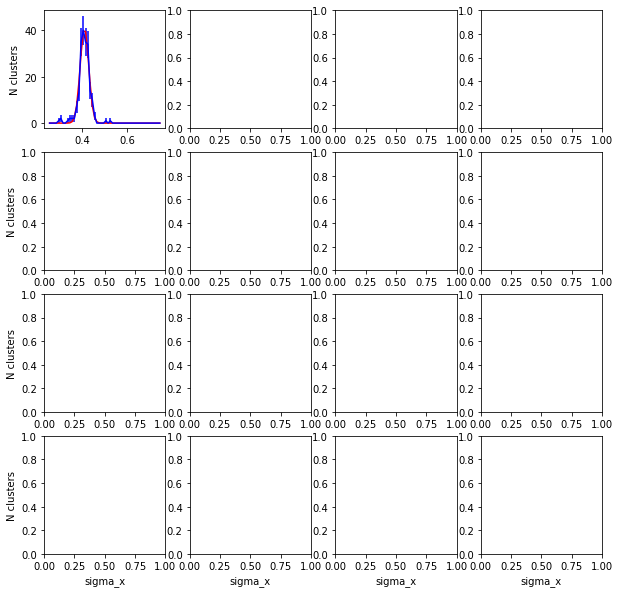

In [43]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, ccd_hists in enumerate(ccd_hists_list):
    sigmax_data = ccd_hists['sigmax']
    hist_data = sigmax_data['hist']
    bin_edges = hist_data[1]
    x = (bin_edges[0:-1] + bin_edges[1:]) /2.
    y = hist_data[0]
    yerr = numpy.sqrt(y)
    fit = sigmax_data['fit']
    indx = i%4
    indy = i//4
    if fit is not None:
        axs[indx][indy].errorbar(x, y, yerr=yerr, c='b')
        axs[indx][indy].plot(x, stats_utils.single_gaussian(x, fit[0]), c='r')
    if indx == 3:
        axs[indx][indy].set_xlabel('sigma_x')
    if indy == 0:
        axs[indx][indy].set_ylabel('N clusters')

In [44]:
afw_display.mtv(work_img) # have a look at an example amp

In [ ]:
FE55_electrons = 1594

### Calculate gain and print them

In [ ]:
for i in range(16):
    print("Gain for amp %s -- %.5f"%(detector[i].getName(), FE55_electrons/fits[i][0][1]))